In [1]:
# %matplotlib ipympl

In [2]:
import torch
import numpy as np
import importlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from time import sleep, time
import sys
import os
DatasetPath = '../Dataset/' 
# append absolute DasetPath to path
DatasetPath = os.path.abspath(DatasetPath)
sys.path.append(DatasetPath)
import Dataset2 as DS

import pandas as pd

importlib.reload(DS)
DatasetContainer = DS.DatasetContainer
ProcessingDatasetContainer = DS.ProcessingDatasetContainer

def PLTParams(figsize = [10,10]):
    plt.rcParams['figure.figsize']=figsize
    plt.rcParams['font.size']=15
PLTParams()



sys.path.append(os.path.abspath('../CherenkovFraction/'))

# Add the ignore warnings
import warnings
warnings.filterwarnings("ignore")

# hostname = os.uname()
# if 'tedtop' in hostname: plt.style.use('/home/fedor-tairli/work/MPLStylefiles/Vscode_DarkModern_Invisible.mplstyle')


In [3]:
def IndexToXY(indices,return_tensor=False):
    indices = indices -1
    Xs = indices//22
    Ys = indices%22
    if return_tensor: return Xs.int(),Ys.int()
    else:             return Xs.int().tolist(),Ys.int().tolist()



#### Import Datasets

In [4]:
DataPath = os.path.abspath('../Data/Proccessed/')
print('DataPath:',DataPath)

DataPath: /home/fedor-tairli/work/CDEs/Data/Proccessed


In [5]:
# Importing Dataset
# Cause it takes a while to lad this thing introduce a check if its already laoded into globals
CheckGlobals = True 
LoadTraces = True

if CheckGlobals: 
    if 'Dataset' in globals():
        print('Dataset already loaded')
        if len(Dataset.Event_level_keys.keys())<1:
            print('Dataset Event_level_keys is None, reloading Dataset')
            Dataset.Load(DataPath,'CDEsDataset' ,LoadTraces=LoadTraces)
    else:
        print('Loading Dataset')
        Dataset = DatasetContainer()
        Dataset.Load(DataPath,'CDEsDataset' ,LoadTraces=LoadTraces)

# Unfuck the Dataset Keys, cuase the EventID string should have a capital D....
if 'EventId_1/2' in Dataset.Event_level_keys.keys():
    Dataset.Event_level_keys['EventID_1/2'] = Dataset.Event_level_keys.pop('EventId_1/2')
    Dataset.Event_level_keys['EventID_2/2'] = Dataset.Event_level_keys.pop('EventId_2/2')
    print('Replaced the EventID Keys, with proper ones')
else:
    print('EventID Keys already replaced')

Loading Dataset
Loading CDEsDataset
EventID Keys already replaced


In [6]:
print('Event level keys:')
for key in Dataset.Event_level_keys.keys(): print('    ',key)
print('Pixel level keys:')
for key in Dataset.Pixel_level_keys.keys(): print('    ',key)

Event level keys:
     EventID_1/2
     EventID_2/2
     Rec_Level
     Event_Class
     Primary
     Gen_LogE
     Gen_CosZenith
     Gen_Xmax
     Gen_dEdXmax
     Gen_SDPPhi
     Gen_SDPTheta
     Gen_Chi0
     Gen_Rp
     Gen_T0
     Gen_CoreEyeDist
     Gen_CherenkovFraction
     Rec_LogE
     Rec_CosZenith
     Rec_Xmax
     Rec_dEdXmax
     Rec_SDPPhi
     Rec_SDPTheta
     Rec_Chi0
     Rec_Rp
     Rec_T0
     Rec_CoreEyeDist
     Rec_CherenkovFraction
Pixel level keys:
     PixelID
     TelID
     EyeID
     Status
     Charge
     Theta
     Phi
     TimeOffset
     PulseStart
     PulseCentroid
     PulseStop


In [7]:
AllPossiblePixelDirections = pd.read_csv('../ReadingData/camera_view_table_with_HEAT_down.txt',sep=' ',header=None,names = ['EyeID','TelID','PixID','Theta','Phi'])

In [8]:
AllPossiblePixelDirections.head()

,EyeID,TelID,PixID,Theta,Phi
0,1,1,1,1.61140,358.419
1,1,1,2,2.86980,359.174
2,1,1,3,4.13764,358.434
3,1,1,4,5.38773,359.205
4,1,1,5,6.66357,358.476


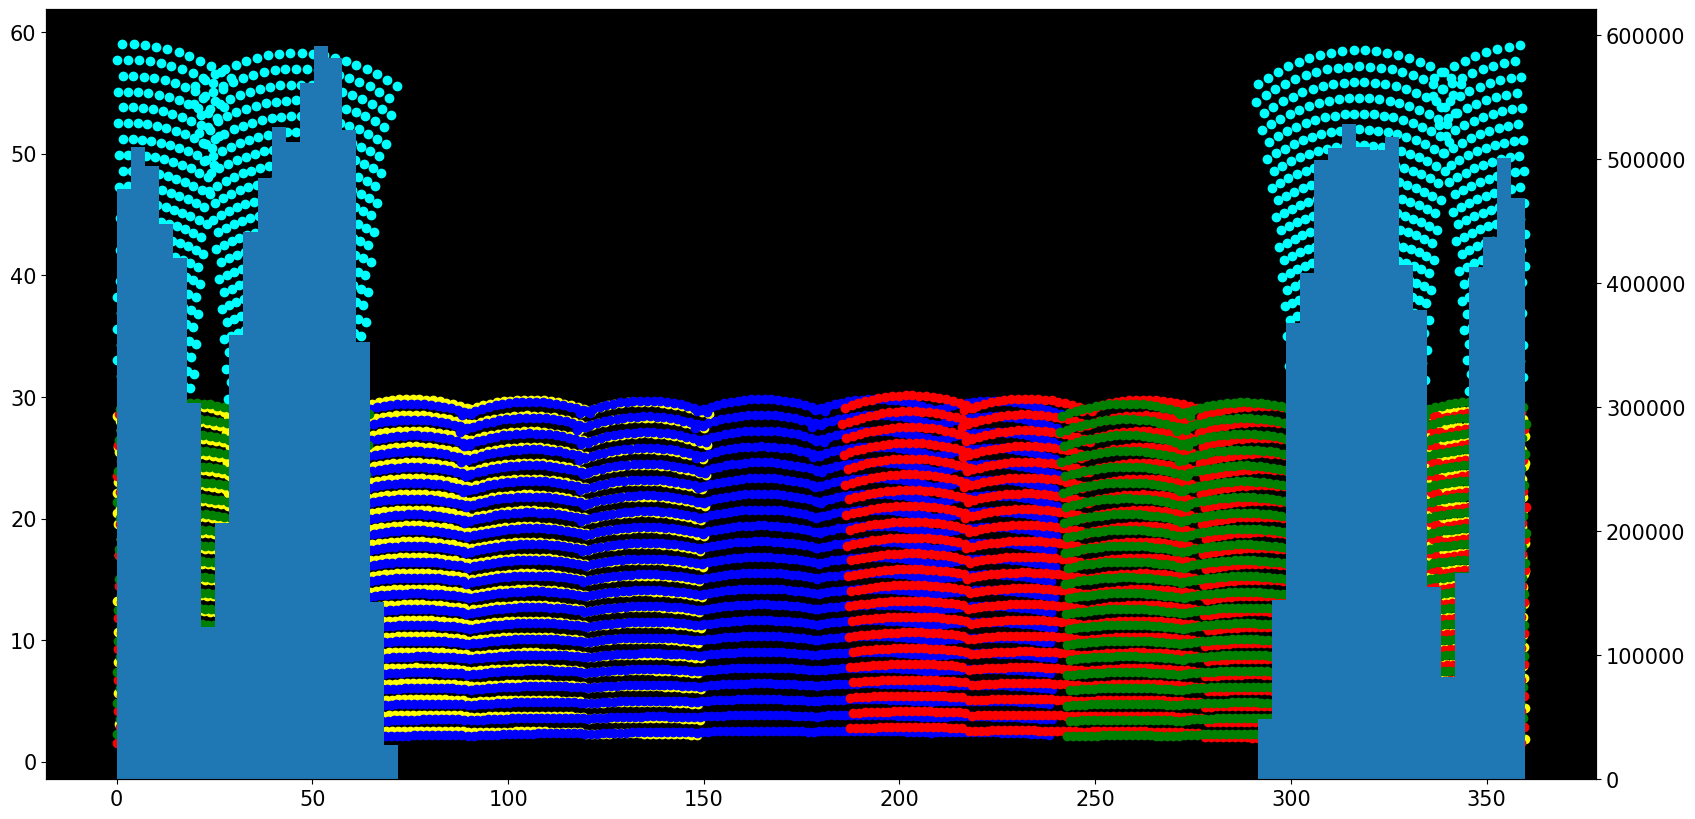

In [9]:
colors = ['yellow','blue','red','green','cyan']
plt.figure(figsize = [20,10])
plt.gca().set_facecolor('black')
for iEye in range(1,6):
    Mask = AllPossiblePixelDirections.EyeID == iEye
    Thetas = AllPossiblePixelDirections.Theta[Mask]
    Phis   = AllPossiblePixelDirections.Phi[Mask]
    plt.scatter(Phis,Thetas,c = colors[iEye-1])
    
ax2 = plt.gca().twinx()
CO_BackwallAngle = 243.0219
HE_BackwallAngle = 273.0
AllThetas = Dataset.get_pixel_values('Theta')
# plt.hist(AllThetas,bins=100)
AllPhis   = Dataset.get_pixel_values('Phi')
X = AllPhis+HE_BackwallAngle
X[X>360] -= 360
ax2.hist(X,bins=100)
plt.show()

#### XmaxEnergy Normalisations


Mean Xmax: 591.5311
STD Xmax: 72.64725


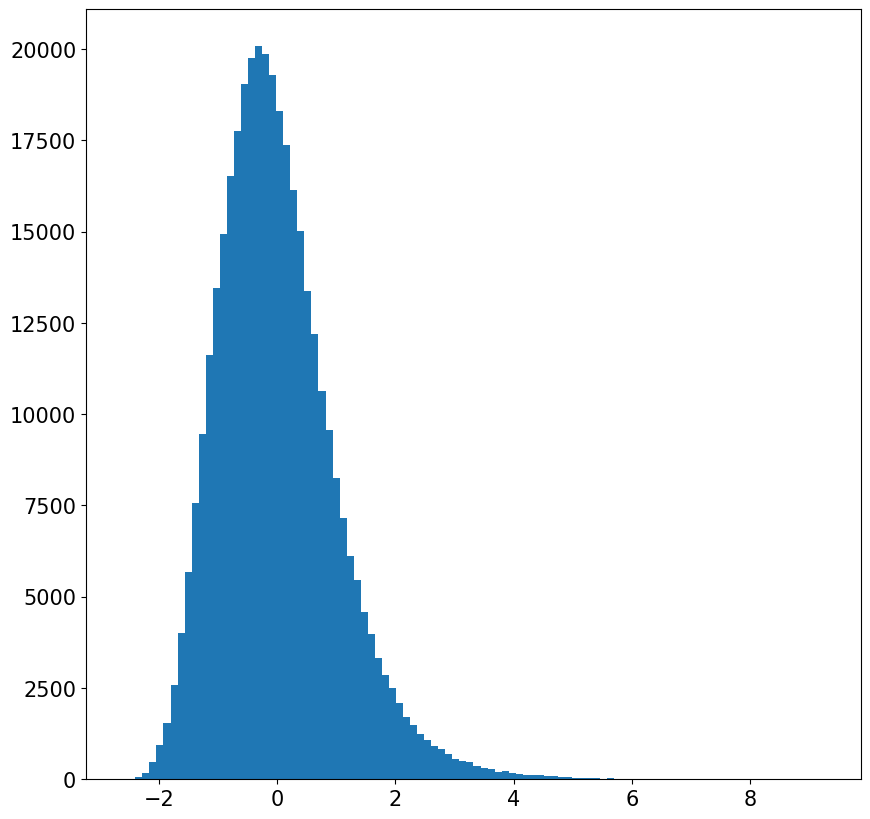

In [10]:
All_Xmax = Dataset.get_values('Gen_Xmax').numpy()

Mean_Xmax = np.mean(All_Xmax)
STD_Xmax  = np.std(All_Xmax)

print('Mean Xmax:',Mean_Xmax)
print('STD Xmax:',STD_Xmax)
# Normalise Xmax to 1000 g/cm^2
X = (All_Xmax - Mean_Xmax)/STD_Xmax

plt.figure(figsize = (10,10))
plt.hist(X,bins=100)
plt.show()

Mean Energy: 16.148266
STD Energy: 0.4755162


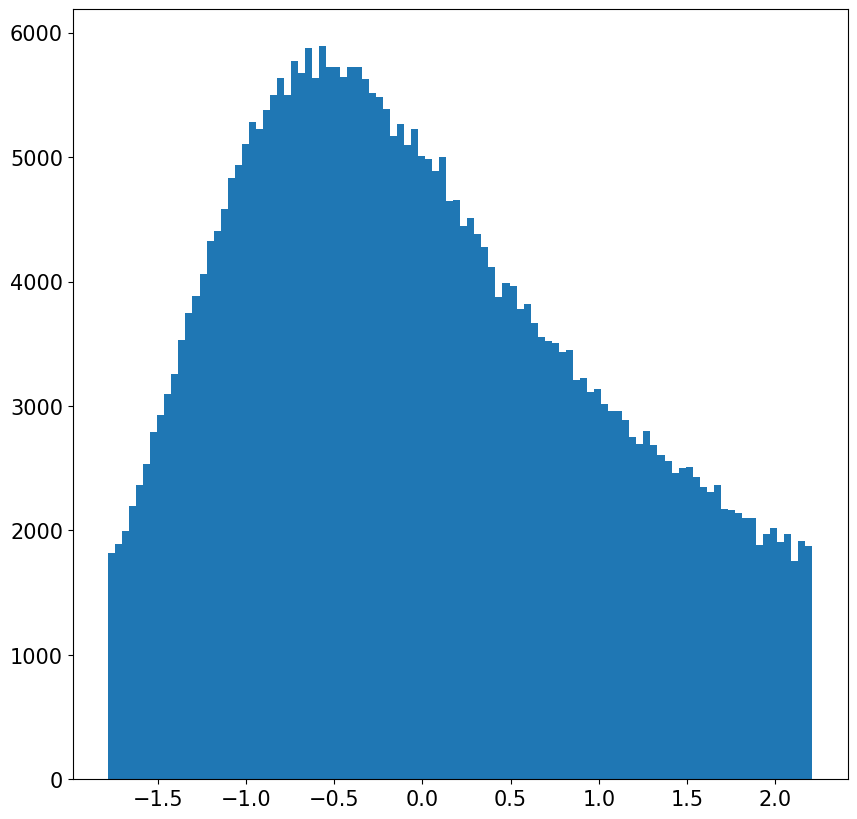

In [11]:
All_Energy = Dataset.get_values('Gen_LogE').numpy()

Energy_Mean = np.mean(All_Energy)
Energy_STD  = np.std(All_Energy)
print('Mean Energy:',Energy_Mean)
print('STD Energy:',Energy_STD)
X = (All_Energy - Energy_Mean)/Energy_STD

plt.figure(figsize = (10,10))
plt.hist(X,bins=100)
plt.show()

In [12]:
# Produce the truncated Colormap for the shower axis
from matplotlib.colors import LinearSegmentedColormap

# Create a truncated version of the plasma colormap (first 90%)
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = LinearSegmentedColormap.from_list(
        f'truncated_{cmap.name}', 
        cmap(np.linspace(minval, maxval, n))
    )
    return new_cmap

# Original plasma colormap
plasma = plt.get_cmap('plasma_r')

# Truncated colormap: first 90%
truncated_plasma = truncate_colormap(plasma, 0.05, 1)


(15.300000190734863, 17.200000762939453)

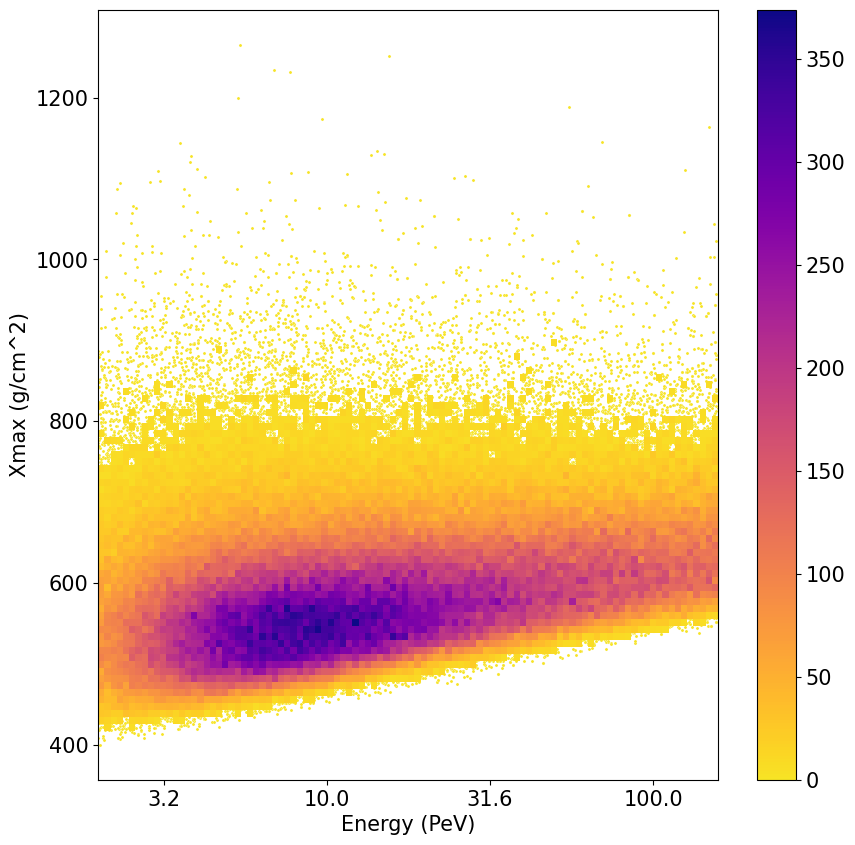

In [13]:
All_Xmax = Dataset.get_values('Gen_Xmax').numpy()
All_Energy = Dataset.get_values('Gen_LogE').numpy()


Normalise = False
if Normalise:
    X = (All_Energy - Energy_Mean)/Energy_STD
    Y = (All_Xmax - Mean_Xmax)/STD_Xmax
    Xlabel = 'Normalised Energy'
    Ylabel = 'Normalised Xmax'
else:

    X = All_Energy
    Y = All_Xmax
    Xlabel = 'Energy (PeV)'
    Ylabel = 'Xmax (g/cm^2)'


plt.figure(figsize = (10,10))
sns.scatterplot(x=X, y=Y, color = truncated_plasma(0.0), s=5)
sns.histplot(x=X, y=Y, bins=100,cmap = truncated_plasma, cbar=True, pthresh=0.01)
plt.xlabel(Xlabel)
plt.ylabel(Ylabel)

# Oonvert Xticks to EeV

if Normalise:
    pass
else:
    Xticks = plt.xticks()[0][::2]
    plt.xticks(ticks=Xticks)
    Xticks = [f'{10**(x-15):.1f}' for x in Xticks]
    plt.xticks(plt.xticks()[0],Xticks)

plt.xlim(min(X),max(X))
    

(15.300000190734863, 17.200000762939453)

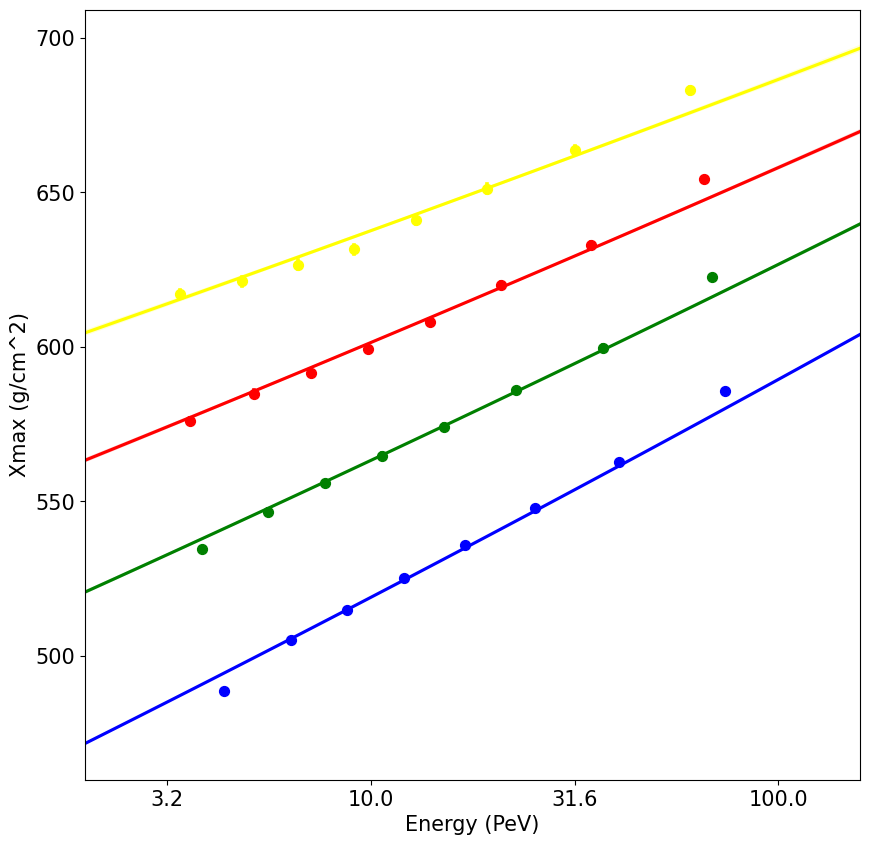

In [14]:
All_Xmax = Dataset.get_values('Gen_Xmax').numpy()
All_Energy = Dataset.get_values('Gen_LogE').numpy()
ALL_Primaries = Dataset.get_values('Primary').numpy()
# [ 2004.  2212.  7014. 26056.] primaries, make them equal to 0,1,2,3
PrimaryColorDict = {2004:'red', 2212:'yellow', 7014:'green', 26056:'blue'}




Normalise = False
if Normalise:
    X = (All_Energy - Energy_Mean)/Energy_STD
    Y = (All_Xmax - Mean_Xmax)/STD_Xmax
    Xlabel = 'Normalised Energy'
    Ylabel = 'Normalised Xmax'
else:

    X = All_Energy
    Y = All_Xmax
    Xlabel = 'Energy (PeV)'
    Ylabel = 'Xmax (g/cm^2)'


plt.figure(figsize = (10,10))
for iPrimary in np.unique(ALL_Primaries):
    Mask = ALL_Primaries == iPrimary
    # plt.scatter(X[Mask], Y[Mask], c=PrimaryColorDict[iPrimary], s=1, label=f'Primary {iPrimary}')
    # use seaborn to plot the averages in each primary in 8 bins
    sns.regplot(x=X[Mask], y=Y[Mask], color=PrimaryColorDict[iPrimary], x_estimator=np.mean, x_bins=8,order = 2)
# sns.scatterplot(x=X, y=Y, c = ALL_Primaries, s=1)
plt.xlabel(Xlabel)
plt.ylabel(Ylabel)

# Oonvert Xticks to EeV

if Normalise:
    pass
else:
    Xticks = plt.xticks()[0][::2]
    plt.xticks(ticks=Xticks)
    Xticks = [f'{10**(x-15):.1f}' for x in Xticks]
    plt.xticks(plt.xticks()[0],Xticks)

plt.xlim(min(X),max(X))
    

N: 226489
Event Energy: 17.15 Lg(E/eV)
Event Xmax: 599.32 g/cm^2
Event Primary: 7014.0


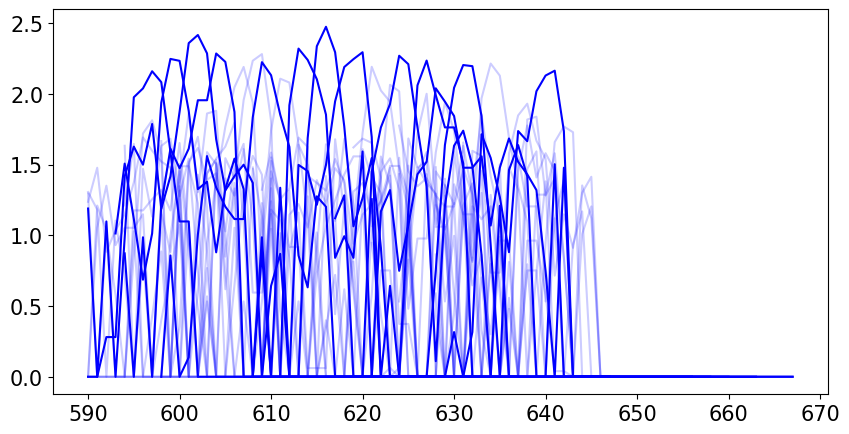

In [15]:
N = np.random.randint(len(Dataset))
print('N:',N)

Event = Dataset.get_event_by_index(N)

print(f'Event Energy: {Event.get_value("Gen_LogE"):.2f} Lg(E/eV)')
print(f'Event Xmax: {Event.get_value("Gen_Xmax"):.2f} g/cm^2')
print(f'Event Primary: {Event.get_value("Primary")}')

PulseStarts = Event.get_pixel_values('PulseStart').numpy()
Traces = torch.log10(torch.clip(Event.get_trace_values(),0)+1).numpy()
Status = Event.get_pixel_values('Status').numpy()
iPix_MaxCharge = torch.argmax(Event.get_pixel_values('Charge')).item()

iPix_MaxCharge_PulseStart = PulseStarts[iPix_MaxCharge]

PulseStarts_Mask = np.abs(PulseStarts - iPix_MaxCharge_PulseStart) < 40

PulseStarts = PulseStarts[PulseStarts_Mask]
Traces = Traces[PulseStarts_Mask,:]
Status = Status[PulseStarts_Mask]


plt.figure(figsize = (10,5))
for i in range(len(PulseStarts)):
    TimeBins = np.arange(40)+PulseStarts[i]
    if Status[i] >0: plt.plot(TimeBins, Traces[i,:],color = 'blue')
    else: plt.plot(TimeBins, Traces[i,:],color ='blue',alpha=0.2)






(array([6.797830e+05, 7.498160e+05, 8.262950e+05, 9.100190e+05,
        1.006198e+06, 1.115614e+06, 1.239448e+06, 1.379693e+06,
        1.535448e+06, 1.711077e+06, 1.900030e+06, 2.094488e+06,
        2.295581e+06, 2.497324e+06, 2.724952e+06, 2.992384e+06,
        3.297624e+06, 3.618508e+06, 3.920795e+06, 4.233713e+06,
        4.582692e+06, 4.922424e+06, 5.239667e+06, 5.560320e+06,
        5.834522e+06, 6.068798e+06, 6.231080e+06, 6.317931e+06,
        6.304675e+06, 6.178687e+06, 5.947727e+06, 5.598013e+06,
        5.147554e+06, 4.621699e+06, 4.050295e+06, 3.461653e+06,
        2.901940e+06, 2.398099e+06, 1.974003e+06, 1.633152e+06,
        1.382131e+06, 1.197441e+06, 1.067810e+06, 9.812720e+05,
        9.169330e+05, 8.642590e+05, 8.218320e+05, 7.786680e+05,
        7.394620e+05, 7.005820e+05, 6.568770e+05, 6.161330e+05,
        5.761110e+05, 5.358150e+05, 4.992760e+05, 4.619190e+05,
        4.259040e+05, 3.916380e+05, 3.597640e+05, 3.301890e+05,
        3.023060e+05, 2.769230e+05, 2.54

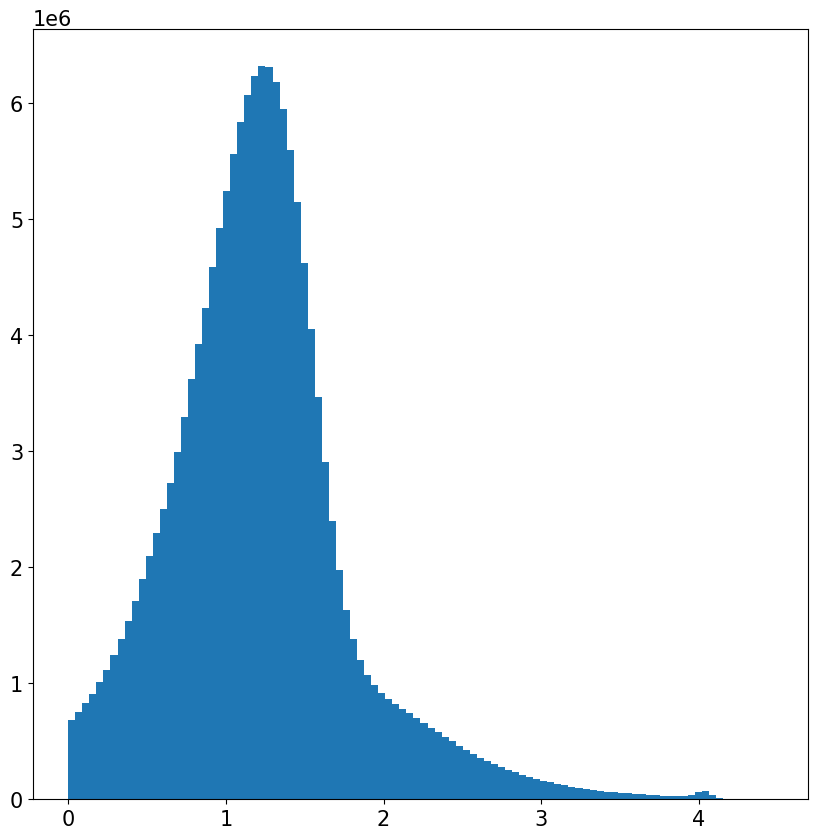

In [16]:
Traces = Dataset.get_trace_values().flatten().numpy()
Traces = Traces[Traces>1]

Traces = np.log10(Traces)

plt.figure(figsize = (10,10))
plt.hist(Traces,bins=100)
# plt.yscale('log')


#### Testing the Rec and Mean_Guess Metrics

In [27]:
All_Xmax_Tru   = Dataset.get_values('Gen_Xmax')
All_Energy_Tru = Dataset.get_values('Gen_LogE')

All_Xmax_Rec   = Dataset.get_values('Rec_Xmax')
All_Energy_Rec = Dataset.get_values('Rec_LogE')

All_Xmax_Mean   = torch.mean(All_Xmax_Tru,dim=0).item()*torch.ones_like(All_Xmax_Tru)
All_Energy_Mean = torch.mean(All_Energy_Tru,dim=0).item()*torch.ones_like(All_Energy_Tru)
print('All_Xmax_Mean:',torch.mean(All_Xmax_Tru,dim=0).item())
print('All_Energy_Mean:',torch.mean(All_Energy_Tru,dim=0).item())

Pred   = torch.stack((All_Xmax_Mean,All_Energy_Mean),dim=1).numpy()
Truth  = torch.stack((All_Xmax_Tru ,All_Energy_Tru ),dim=1).numpy()
Rec    = torch.stack((All_Xmax_Rec ,All_Energy_Rec ),dim=1).numpy()


# Make the Failed Predictions Cut
Cut = np.isinf(All_Energy_Rec.numpy())
print(f'Starting with {len(Cut)} points')
print(f'Removing {sum(Cut)} points with Failed Predictions, and keeping {len(Cut)-sum(Cut)} points')

Pred   = Pred[~Cut,:]
Truth  = Truth[~Cut,:]
Rec    = Rec[~Cut,:]

All_Xmax_Mean: 591.5310668945312
All_Energy_Mean: 16.148265838623047
Starting with 375911 points
Removing 101339 points with Failed Predictions, and keeping 274572 points


In [28]:
EventClasses = Dataset.get_values('Event_Class').numpy()
print(np.unique(EventClasses))
event_class_labels = {
    0: 'Shower Candidate',
    1: 'Close Shower',
    2: 'Horizontal Shower',
    3: 'Large Event',
    4: 'Muon + Noise',
    5: 'Long Muon',
    6: 'Noise',
    7: 'Muon'
}
EventClasses = EventClasses[~Cut]
Cut = (EventClasses <= 3)

print(f'Removing {sum(~Cut)} points with Event Classes > 3, and keeping {len(Cut)-sum(~Cut)} points')

Pred  = Pred[Cut,:]
Truth = Truth[Cut,:]
Rec   = Rec[Cut,:]

[0.0000000e+00 1.0000000e+00 2.0000000e+00 3.0000000e+00 4.0000000e+00
 5.0000000e+00 6.0000000e+00 7.0000000e+00 4.2949673e+09]
Removing 130190 points with Event Classes > 3, and keeping 144382 points


Total Points before cuts 144382
Xmax Total Points after cuts 125815
LogE Total Points after cuts 144371


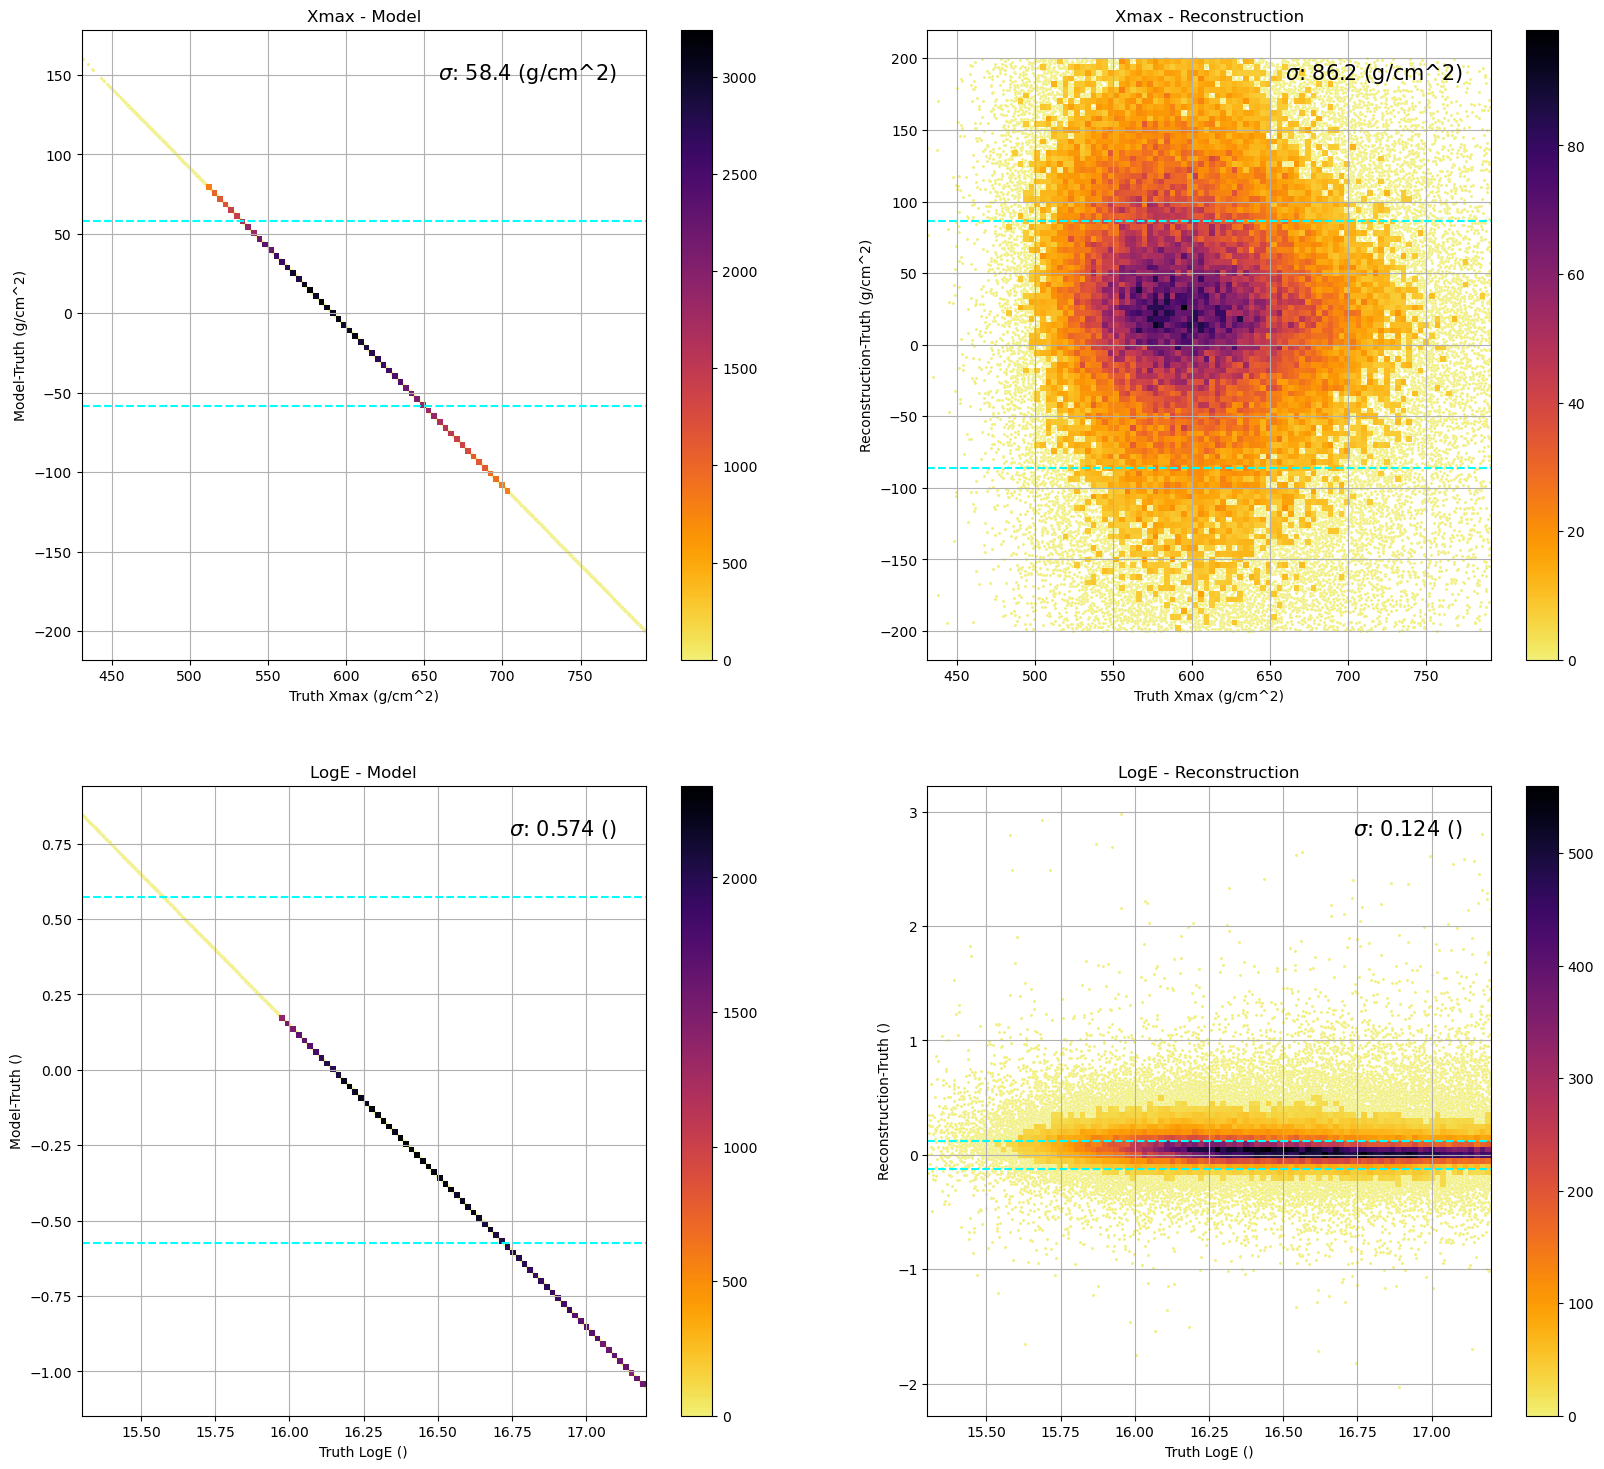

In [29]:
from matplotlib.colors import LinearSegmentedColormap

# Create a truncated version of the inferno colormap (first 90%)
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = LinearSegmentedColormap.from_list(
        f'truncated_{cmap.name}', 
        cmap(np.linspace(minval, maxval, n))
    )
    return new_cmap

# Original inferno colormap
inferno = plt.get_cmap('inferno_r')

# Truncated colormap: first 90%
truncated_inferno = truncate_colormap(inferno, 0.05, 1)

def CombinedDeviationPlots(TruthKeys,TruthUnits,Truth,Pred,Rec):
    plt.style.use('default')
    fig, ax = plt.subplots(len(TruthKeys),2, figsize=(20,9*len(TruthKeys)))
    print(f'Total Points before cuts {len(Truth)}')
    for i in range(len(TruthKeys)):
        X  = Truth[:, i] if TruthUnits[i] != 'rad' else Truth[:, i]/np.pi*180
        Yp = Pred[:, i] - Truth[:, i] if TruthUnits[i] != 'rad' else (Pred[:, i] - Truth[:, i])/np.pi*180
        Yr = Rec [:, i] - Truth[:, i] if TruthUnits[i] != 'rad' else (Rec [:, i] - Truth[:, i])/np.pi*180
        
        # Scaling Cuts
        if   TruthKeys[i] == 'SDPTheta': cut = (np.abs(Yp)>0) #  (np.abs(Yp)<20)    & (np.abs(Yr)<20)
        elif TruthKeys[i] == 'SDPPhi'  : cut = (np.abs(Yp)>0) #  (np.abs(Yp)<20)    & (np.abs(Yr)<20) #   & (np.abs(X)<50)
        elif TruthKeys[i] == 'Chi0'    : cut = (np.abs(Yp)<20)    & (np.abs(Yr)<20)
        elif TruthKeys[i] == 'Rp'      : cut = (np.abs(Yp)<5000)  & (np.abs(Yr)<5000)
        elif TruthKeys[i] == 'CEDist'  : cut = (np.abs(Yp)<5000)  & (np.abs(Yr)<5000)
        elif TruthKeys[i] == 'T0'      : cut = (np.abs(Yp)<10000) & (np.abs(Yr)<10000)
        elif TruthKeys[i] == 'Xmax'    : cut = (np.abs(Yp)<200)   & (np.abs(Yr)<200)  & (X>100)
        elif TruthKeys[i] == 'LogE'    : cut = (X>0)              & (np.abs(Yp)<3)    & (np.abs(Yr)<3)
        elif TruthKeys[i] == 'z'       : cut = (X>0.4) 
        else: cut = (np.abs(Yp)>0)

        
        X = X[cut]
        Yp = Yp[cut]
        Yr = Yr[cut]

        # Secondary Y_lim cuts for scaling
        # Yp_STD = np.percentile(np.abs(Yp),68)
        # cut = (np.abs(Yp)<5*Yp_STD) & (np.abs(Yr)<5*Yp_STD)
        # X  = X [cut]
        # Yp = Yp[cut]
        # Yr = Yr[cut]
        print(f'{TruthKeys[i]} Total Points after cuts {len(X)}')
        # sns.scatterplot(x=X, y=Yp, ax=ax[i,0], s=5,color='orange')
        # sns.scatterplot(x=X, y=Yr, ax=ax[i,1], s=5,color='orange')

        sns.scatterplot(x=X, y=Yp, ax=ax[i,0], s=5,color=truncated_inferno(0))
        sns.scatterplot(x=X, y=Yr, ax=ax[i,1], s=5,color=truncated_inferno(0))


        sns.histplot(x=X, y=Yp, ax=ax[i,0], bins=100, pthresh=0.1,cmap = truncated_inferno,cbar = True)
        sns.histplot(x=X, y=Yr, ax=ax[i,1], bins=100, pthresh=0.1,cmap = truncated_inferno,cbar = True)
        if TruthUnits[i] != 'rad': 
            ax[i,0].set_ylabel(f'Model-Truth ({TruthUnits[i]})')
            ax[i,0].set_xlabel(f'Truth {TruthKeys[i]} ({TruthUnits[i]})')

            ax[i,1].set_ylabel(f'Reconstruction-Truth ({TruthUnits[i]})')
            ax[i,1].set_xlabel(f'Truth {TruthKeys[i]} ({TruthUnits[i]})')

            
        else:                      
            ax[i,0].set_ylabel(f'Model-Truth (degrees)')
            ax[i,0].set_xlabel(f'Truth {TruthKeys[i]} (degrees)')

            ax[i,1].set_ylabel(f'Reconstruction-Truth (degrees)')
            ax[i,1].set_xlabel(f'Truth {TruthKeys[i]} (degrees)')
        
        ax[i,0].set_title(f'{TruthKeys[i]} - Model')
        ax[i,1].set_title(f'{TruthKeys[i]} - Reconstruction')

        ax[i,0].set_xlim(min(X),max(X))
        ax[i,1].set_xlim(min(X),max(X))

        ax[i,0].grid()
        ax[i,1].grid()

        # ax[0,1].set_facecolor('lightgrey')
        # ax[1,1].set_facecolor('lightgrey')


        # 68th Percentile
        Percentile68_p = np.percentile(np.abs(Yp),68)
        Percentile68_r = np.percentile(np.abs(Yr),68)

        # ax[i,0].set_ylim(-Percentile68_p*5,Percentile68_p*5)
        # ax[i,1].set_ylim(-Percentile68_p*5,Percentile68_p*5)



        # Add as a texbox to top right of plot
        if TruthUnits[i]!= 'rad':
            ax[i,0].text(0.95, 0.95, f'$\\sigma$: {Percentile68_p:.3} ({TruthUnits[i]})', verticalalignment='top', horizontalalignment='right', transform=ax[i,0].transAxes, fontsize=15)
            ax[i,1].text(0.95, 0.95, f'$\\sigma$: {Percentile68_r:.3} ({TruthUnits[i]})', verticalalignment='top', horizontalalignment='right', transform=ax[i,1].transAxes, fontsize=15)

        else:
            ax[i,0].text(0.95, 0.95, f'$\\sigma$: {Percentile68_p:.3} (deg)', verticalalignment='top', horizontalalignment='right', transform=ax[i,0].transAxes, fontsize=15)
            ax[i,1].text(0.95, 0.95, f'$\\sigma$: {Percentile68_r:.3} (deg)', verticalalignment='top', horizontalalignment='right', transform=ax[i,1].transAxes, fontsize=15)



        ax[i,0].axhline(Percentile68_p, color='cyan', linestyle='--')
        ax[i,0].axhline(-Percentile68_p, color='cyan', linestyle='--')

        ax[i,1].axhline(Percentile68_r, color='cyan', linestyle='--')
        ax[i,1].axhline(-Percentile68_r, color='cyan', linestyle='--')
        
    return fig
    
TruthKeys = ('Xmax','LogE')
TruthUnits = ('g/cm^2','')
figure = CombinedDeviationPlots(TruthKeys,TruthUnits,Truth,Pred,Rec)
# figure.savefig(f'../Results/{Model_Name}_Combined_Deviation.png')

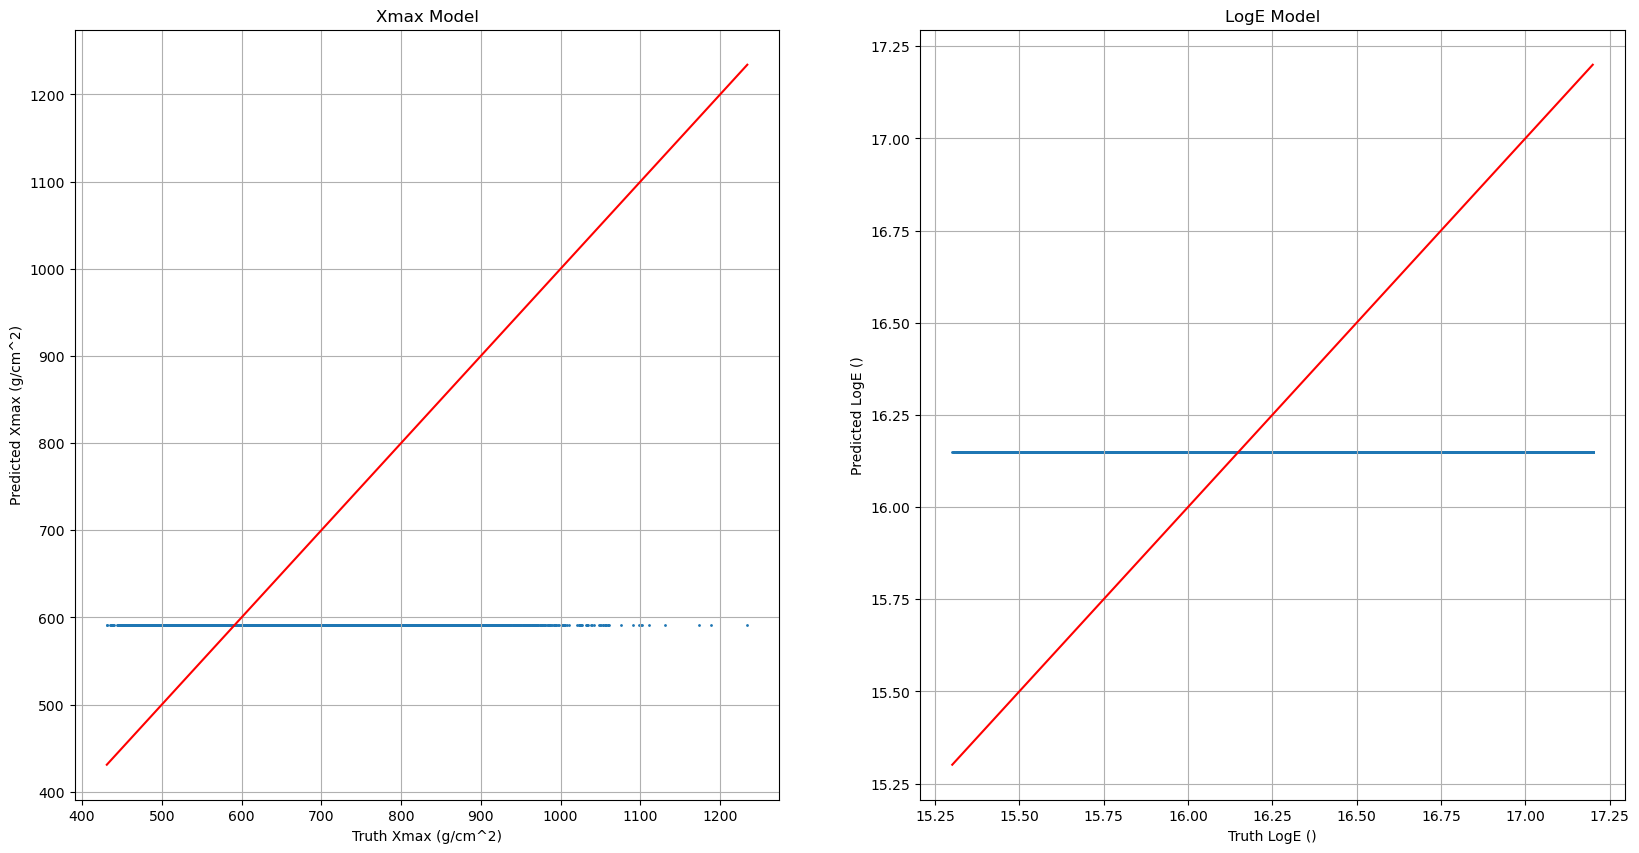

In [30]:
# Easy Scatter Plots of Predicted vs Truth
if "SDPTheta_c" in TruthKeys and "SDPPhi_c" in TruthKeys:
    # The Unnormalise_Truth will return SDPTheta and SDPPhi values, not c/s of either
    TruthKeys  = ['SDPTheta','SDPPhi']
    TruthUnits = ['rad','rad']  # Default Units for SDPTheta and SDPPhi

fig, ax = plt.subplots(1, len(TruthKeys), figsize=(10*len(TruthKeys), 10))

for i in range(len(TruthKeys)):
    ax[i].scatter(Truth[:, i], Pred[:, i], s=1)
    ax[i].plot([min(Truth[:, i]), max(Truth[:, i])], [min(Truth[:, i]), max(Truth[:, i])], 'r')
    if TruthUnits[i] == 'rad': # Change to degrees
        xticks = ax[i].get_xticks()
        ax[i].set_xticklabels([f"{x / np.pi * 180:.0f}°" for x in xticks])
        yticks = ax[i].get_yticks()
        ax[i].set_yticklabels([f"{y / np.pi * 180:.0f}°" for y in yticks])
        ax[i].set_xlabel(f'Truth {TruthKeys[i]} (deg)')
        ax[i].set_ylabel(f'Predicted {TruthKeys[i]} (deg)')
    else:
        ax[i].set_xlabel(f'Truth {TruthKeys[i]} ({TruthUnits[i]})')
        ax[i].set_ylabel(f'Predicted {TruthKeys[i]} ({TruthUnits[i]})')
    ax[i].set_title(f'{TruthKeys[i]} Model')
    ax[i].grid()

plt.show()


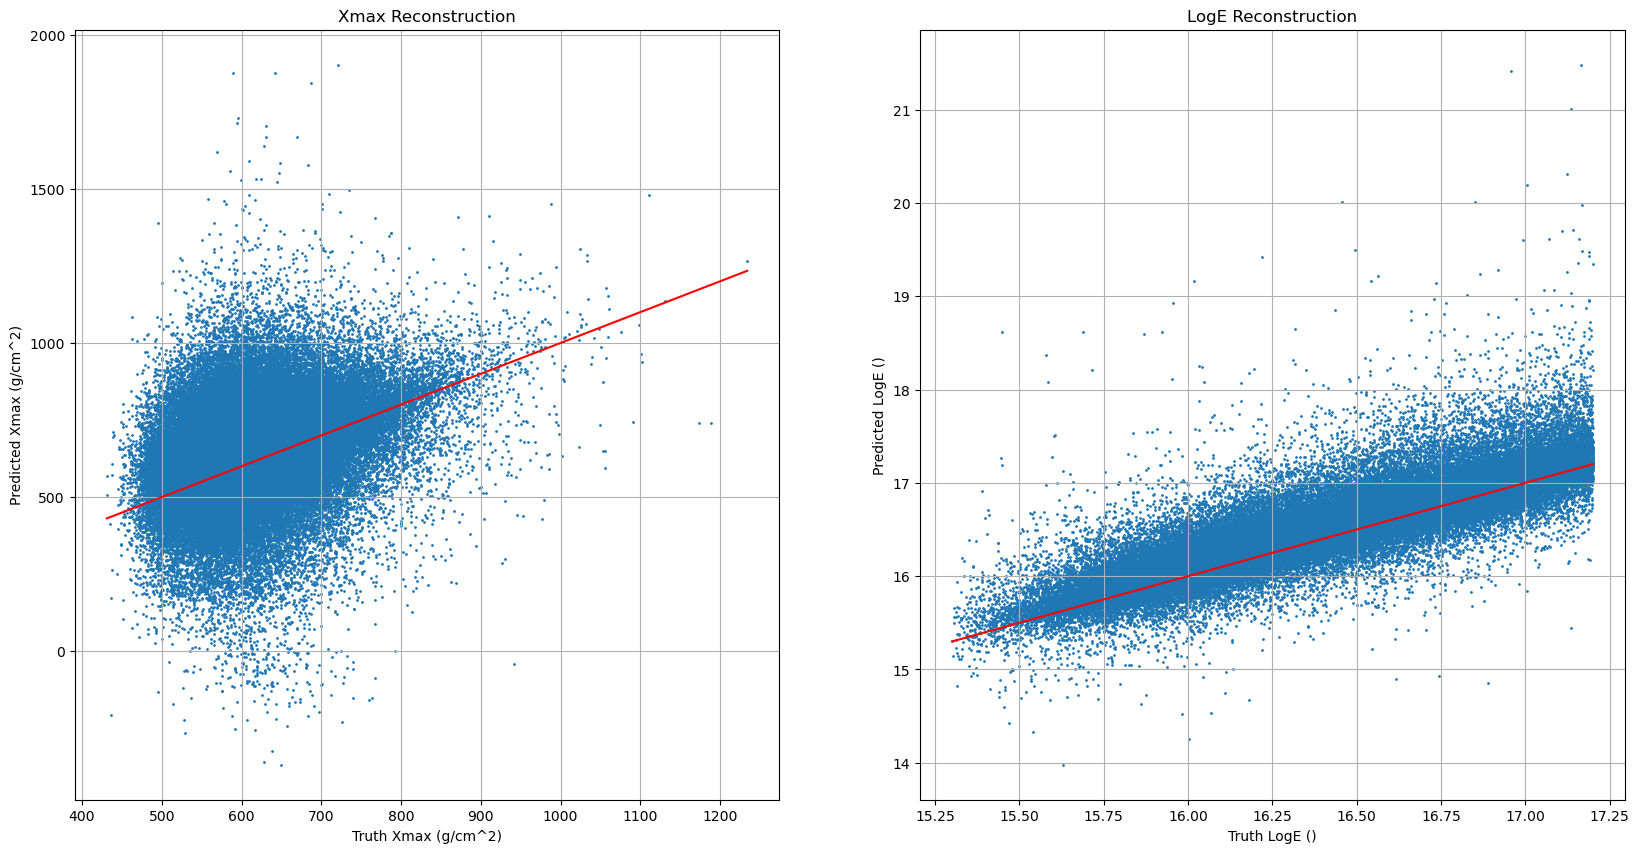

In [31]:
# Easy Scatter Plots of Reconstructed vs Truth
if "SDPTheta_c" in TruthKeys and "SDPPhi_c" in TruthKeys:
    # The Unnormalise_Truth will return SDPTheta and SDPPhi values, not c/s of either
    TruthKeys  = ['SDPTheta','SDPPhi']
    TruthUnits = ['rad','rad']  # Default Units for SDPTheta and SDPPhi
    
fig, ax = plt.subplots(1, len(TruthKeys), figsize=(10*len(TruthKeys), 10))

for i in range(len(TruthKeys)):
    ax[i].scatter(Truth[:, i], Rec[:, i], s=1)
    ax[i].plot([min(Truth[:, i]), max(Truth[:, i])], [min(Truth[:, i]), max(Truth[:, i])], 'r')
    if TruthUnits[i] == 'rad': # Change to degrees
        xticks = ax[i].get_xticks()
        ax[i].set_xticklabels([f"{x / np.pi * 180:.0f}°" for x in xticks])
        yticks = ax[i].get_yticks()
        ax[i].set_yticklabels([f"{y / np.pi * 180:.0f}°" for y in yticks])
        ax[i].set_xlabel(f'Truth {TruthKeys[i]} (deg)')
        ax[i].set_ylabel(f'Predicted {TruthKeys[i]} (deg)')
    else:
        ax[i].set_xlabel(f'Truth {TruthKeys[i]} ({TruthUnits[i]})')
        ax[i].set_ylabel(f'Predicted {TruthKeys[i]} ({TruthUnits[i]})')
    ax[i].set_title(f'{TruthKeys[i]} Reconstruction')
    ax[i].grid()

plt.show()


In [32]:
def Metric_68th_Percentile(Rec,Truth):
    if type(Rec) is not np.ndarray:
        Rec = Rec.numpy()
    if type(Truth) is not np.ndarray:
        Truth = Truth.numpy()
    """
    Calculate the 68th percentile of the absolute difference between Rec and Truth values.
    """
    return np.percentile(np.abs(Rec - Truth), 68)

print('Metric 68th Percentile Rec  Xmax:',Metric_68th_Percentile(All_Xmax_Rec,All_Xmax_Tru))
print('Metric 68th Percentile Mean Xmax:',Metric_68th_Percentile(All_Xmax_Mean,All_Xmax_Tru))
print()
print('Metric 68th Percentile Rec  LogE:',Metric_68th_Percentile(All_Energy_Rec,All_Energy_Tru))
print('Metric 68th Percentile Mean LogE:',Metric_68th_Percentile(All_Energy_Mean,All_Energy_Tru))
print()

Metric 68th Percentile Rec  Xmax: 263.5416
Metric 68th Percentile Mean Xmax: 67.82904

Metric 68th Percentile Rec  LogE: 0.42540056
Metric 68th Percentile Mean LogE: 0.51786613



Removing 0 points with LogE_Rec <= 10e-10
Ebins: [15.3012   15.49108  15.68096  15.87084  16.06072  16.2506   16.440481
 16.63036  16.82024  17.01012  17.2     ]


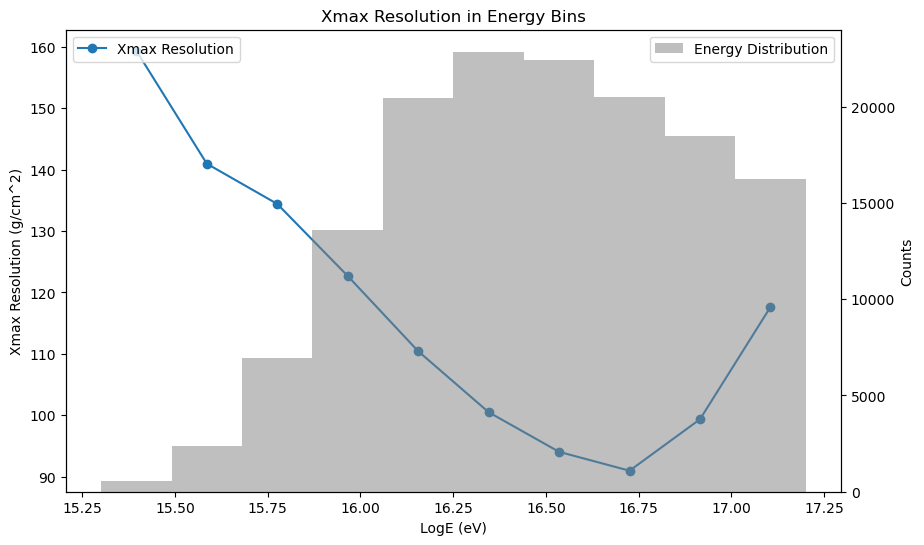

In [33]:
# Test out the Xmax Resolution in energy bins

Xmax_Rec   = Rec[:, 0]
Xmax_Truth = Truth[:, 0]
LogE_Rec   = Rec[:, 1]
LogE_Truth = Truth[:, 1]

if True:
    Mask = LogE_Rec > 10e-10
    print(f'Removing {sum(~Mask)} points with LogE_Rec <= 10e-10')
    Xmax_Rec   = Xmax_Rec[Mask]
    Xmax_Truth = Xmax_Truth[Mask]
    LogE_Rec   = LogE_Rec[Mask]
    LogE_Truth = LogE_Truth[Mask]


Ebins     = np.histogram(LogE_Truth,bins=10)[1]
BinCenters = (Ebins[:-1] + Ebins[1:]) / 2
print('Ebins:',Ebins)

Xmax_Resolution = []
for i in range(len(Ebins)-1):
    Mask = (LogE_Truth >= Ebins[i]) & (LogE_Truth < Ebins[i+1])

    Xmax_Resolution.append(Metric_68th_Percentile(Xmax_Rec[Mask],Xmax_Truth[Mask]))

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(BinCenters, Xmax_Resolution, marker='o', label = 'Xmax Resolution')
ax2 = ax.twinx()
ax2.hist(LogE_Truth, bins=Ebins, alpha=0.5, color='gray', label='Energy Distribution')

ax.set_xlabel('LogE (eV)')
ax.set_ylabel('Xmax Resolution (g/cm^2)')
ax2.set_ylabel('Counts')
ax.set_title('Xmax Resolution in Energy Bins')
ax.legend(loc='upper left')
ax2.legend(loc='upper right')

Text(0, 0.5, 'Counts')

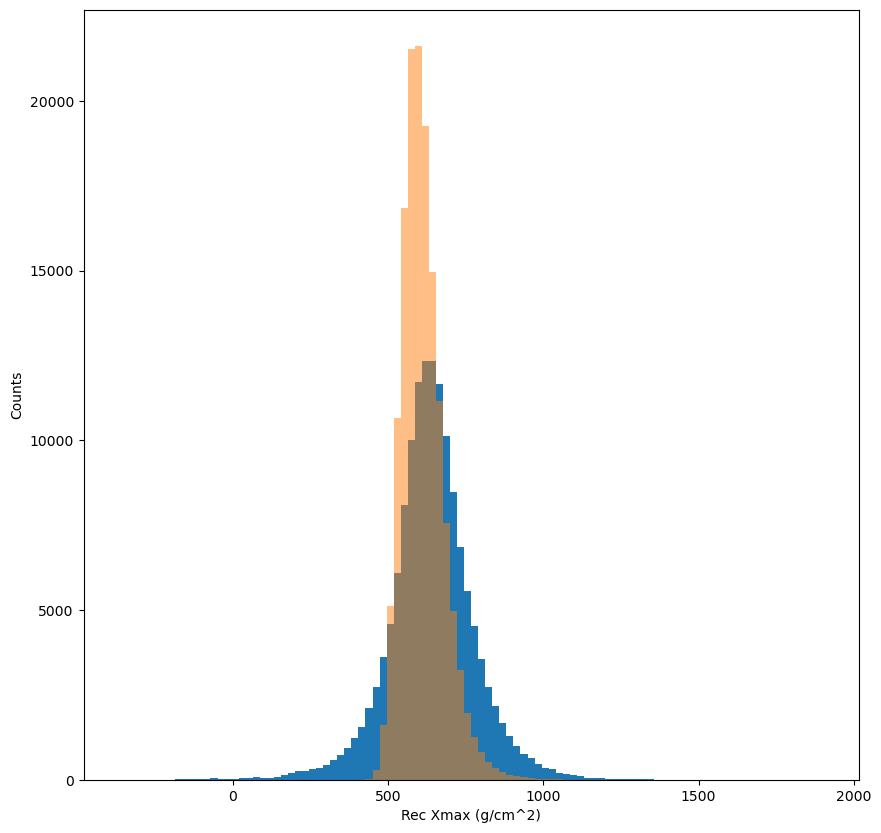

In [34]:
All_Rec_Xmax = Rec[:, 0]
All_Tru_Xmax = Truth[:, 0]
plt.figure(figsize = (10,10))
bins = plt.hist(All_Rec_Xmax,bins=100)

plt.hist(All_Tru_Xmax,bins=bins[1],alpha=0.5)
plt.xlabel('Rec Xmax (g/cm^2)')
plt.ylabel('Counts')